#  Détection de surconsommations résidentielles par analyse des résidus de prévision — Mémoire M2 IASD
_Auteure : Pénélope Millet — Année : 2024-2025_

## Objet
Ce notebook regroupe les éléments de code essentiels qui soutiennent l'étude du mémoire : il montre comment les données brutes sont transformées, comment les modèles sont entraînés/évalués, puis comment les anomalies sont détectées et agrégées en épisodes.  

## Contenu
- **Préparation des variables** : construction de lags, moyennes glissantes et indicateurs calendaires.
- **Apprentissage & évaluation** : protocoles S1 et S2.
- **Détection** : méthodes par quantiles (globale et contextuel) et variantes zero-shot/progressives.
- **Métriques** : agrégation en épisodes et calcul des indicateurs rapportés.

## Périmètre
- Le notebook se concentre sur les fonctions clés (pipeline, modèles, détection, métriques).

## Prérequis
- Python 3.x avec : `pandas`, `numpy`, `scikit-learn`, `scipy`, et `matplotlib`.

## Limites
- Les résultats numériques ici doivent être interprétés à la lumière des hypothèses et limites décrites dans le mémoire.
- Les performances peuvent varier selon la version des bibliothèques et la machine d'exécution.

## Référence
Pour le cadre théorique, les décisions de design et l'analyse critique des résultats, se référer au mémoire :  
**Millet, P. (2025). _Détection de surconsommations résidentielles par analyse des résidus de prévision_ (Mémoire M2 IASD).**


# Setup & Config

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, time, uuid, joblib, tempfile
import time

from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# Configuration
RANDOM_STATE = 42
N_JOBS = -1
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Colonnes standardisées pour tout le notebook
TARGET_COL = "Aggregate"

DATA_PATH = '/content/REFIT_15min.csv'


# Préparation des données

In [ ]:
import glob
files = glob.glob('/content/REFIT/House_*.csv')

In [ ]:
dfs = []
granularity = '15min'  # pas temporel cible pour l’agrégation

for file in files:
    print(f"Processing {file}")
    df = pd.read_csv(file)
    print("Colonnes :", df.columns.tolist())

    # Construction de l’horodatage à partir de la colonne brute 'Time'
    df['Datetime'] = pd.to_datetime(df['Time'], errors='coerce')

    # Suppression des lignes sans horodatage
    df = df.dropna(subset=['Datetime'])

    # ---- Sélection des colonnes numériques (Aggregate + appareils) ----
    cols_num = ['Aggregate']

    appareils = [
        col for col in df.columns
        if col not in ['Time', 'Datetime', 'Aggregate']
        and df[col].dtype in ['float64', 'int64']
    ]
    cols_num += appareils
    cols_num = ['Datetime'] + cols_num

    # Sous-ensemble minimal pour le traitement (horodatage + mesures)
    df = df[cols_num]

    # Normalisation de type : conversion en numérique pour les appareils
    for col in appareils:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.set_index('Datetime')

    # Agrégation à la granularité cible (moyenne sur chaque fenêtre)
    df_resamp = df.resample(granularity).mean().reset_index()

    # Identifiant de foyer
    house_id = file.split('House_')[1].split('.')[0]
    df_resamp['house_id'] = house_id

    dfs.append(df_resamp)

# Fusion de l’ensemble des foyers en un tableau unique
all_data = pd.concat(dfs, ignore_index=True)


# Chargement et nettoyage des données

In [ ]:
df = pd.read_csv(DATA_PATH)
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [ ]:
n0 = len(df)

# Compte des lignes supprimées (NaN sur Aggregate) par foyer
suppr_par_foyer = (
    df.groupby('house_id')['Aggregate']
      .apply(lambda s: s.isna().sum())
      .rename('nb_suppr')
)

# Taux de suppression global
nb_suppr_total = int(suppr_par_foyer.sum())
pct_suppr_total = 100 * nb_suppr_total / n0 if n0 else 0.0

# Nettoyage : suppression des enregistrements sans mesure Aggregate
df = df.dropna(subset=['Aggregate']).copy()

# Restants par foyer (après nettoyage)
restants_par_foyer = df.groupby('house_id').size().rename('nb_restants')

# Fenêtre de couverture temporelle par foyer (après nettoyage)
couverture = (
    df.groupby('house_id')['Datetime']
      .agg(debut_couverture='min', fin_couverture='max')
      .reset_index()
)
for c in ['debut_couverture', 'fin_couverture']:
    couverture[c] = couverture[c].dt.strftime('%Y-%m-%d')

# — Tableau récapitulatif (par foyer) —
recap = (
    pd.concat([suppr_par_foyer, restants_par_foyer], axis=1)
      .fillna(0).astype(int)
      .reset_index()
      .merge(couverture, on='house_id', how='left')
)

recap['nb_init'] = recap['nb_suppr'] + recap['nb_restants']
recap['% suppr'] = (
    100 * recap['nb_suppr'] / recap['nb_init']
).where(recap['nb_init'] > 0, 0).round(1)

# Colonnes finales + tri
recap = recap.loc[:, [
    'house_id', 'nb_init', 'nb_suppr', '% suppr',
    'nb_restants', 'debut_couverture', 'fin_couverture'
]].sort_values('house_id')

print(f"{pct_suppr_total:.2f}% de lignes supprimées au total.")
print(f"Il reste {len(df)} lignes.")
display(recap.head(20))

11.71% de lignes supprimées au total.
Il reste 921931 lignes.


,house_id,nb_init,nb_suppr,% suppr,nb_restants,debut_couverture,fin_couverture
0,1,61340,7370,12.0,53970,2013-10-09,2015-07-10
1,2,59273,14180,23.9,45093,2013-09-17,2015-05-28
2,3,59007,6560,11.1,52447,2013-09-25,2015-06-02
3,4,60863,7488,12.3,53375,2013-10-11,2015-07-07
4,5,62241,5017,8.1,57224,2013-09-26,2015-07-06
5,6,55432,8227,14.8,47205,2013-11-28,2015-06-28
6,7,58865,7260,12.3,51605,2013-11-01,2015-07-08
7,8,53287,5353,10.0,47934,2013-11-01,2015-05-10
8,9,54535,8275,15.2,46260,2013-12-17,2015-07-08
9,10,56351,5471,9.7,50880,2013-11-20,2015-06-30


# Feature engineering

In [ ]:
def create_features(df):
    """
    Crée les features pour prédiction & détection, en restant robuste aux trous temporels.
    """
    # --- Base ---
    df_fe = df.sort_values(['house_id', 'Datetime']).copy()
    df_fe['Datetime'] = pd.to_datetime(df_fe['Datetime'])

    # --- Features temporelles de base ---

    df_fe['hour'] = df_fe['Datetime'].dt.hour
    df_fe['dayofweek'] = df_fe['Datetime'].dt.dayofweek  # 0=Lundi..6=Dimanche

    df_fe['hour_of_week'] = (df_fe['Datetime'].dt.dayofweek * 24 + df_fe['Datetime'].dt.hour).astype(int)

    # Codages cycliques
    df_fe['sin_hour'] = np.sin(2 * np.pi * df_fe['hour'] / 24)
    df_fe['cos_hour'] = np.cos(2 * np.pi * df_fe['hour'] / 24)
    df_fe['sin_dow']  = np.sin(2 * np.pi * df_fe['dayofweek'] / 7)
    df_fe['cos_dow']  = np.cos(2 * np.pi * df_fe['dayofweek'] / 7)

    # --- Lags historiques (15 min, 1 h, 24 h, 7 j) ---
    lag_specs = [
        (15,      'agg_lag_1'),
        (60,      'agg_lag_4'),
        (24*60,   'agg_lag_96'),
        (7*24*60, 'agg_lag_672'),
    ]

    for minutes, colname in lag_specs:
        shifted = df_fe[['house_id', 'Datetime', 'Aggregate']].copy()
        shifted['Datetime'] = shifted['Datetime'] + pd.Timedelta(minutes=minutes)
        shifted = shifted.rename(columns={'Aggregate': colname})
        # merge sur (house_id, Datetime)
        df_fe = df_fe.merge(shifted, on=['house_id', 'Datetime'], how='left')

    # --- Rollings causales par foyer (fenêtres temps, robustes aux trous) ---
    outs = []
    for hid, g in df_fe.groupby('house_id', sort=False):
        gi = g.set_index('Datetime').copy()

        gi['agg_roll_mean_4'] = (
            gi['Aggregate'].rolling('1h', closed='left', min_periods=4).mean()
        )
        gi['agg_roll_mean_96'] = (
            gi['Aggregate'].rolling('24h', closed='left', min_periods=24).mean()
        )
        gi['agg_roll_mean_672'] = (
            gi['Aggregate'].rolling('168h', closed='left', min_periods=96).mean()
        )

        outs.append(gi.reset_index())
    df_fe = pd.concat(outs, ignore_index=True)

    # # Nettoyage final
    df_fe = df_fe.replace([np.inf, -np.inf], np.nan)

    return df_fe


In [ ]:
def get_feature_sets():
    """
    Retourne les jeux de variables utilisés par les modèles.
    """
    base_features = [
        'sin_hour','cos_hour','sin_dow','cos_dow',
        'agg_lag_1','agg_lag_4','agg_lag_96','agg_lag_672',
        'agg_roll_mean_4','agg_roll_mean_96','agg_roll_mean_672'
    ]
    appliance_features = [f'Appliance{i}' for i in range(1, 10)]
    return {
        "realiste":     base_features,
        "enrichi": base_features + appliance_features,
    }

In [ ]:
df_fe = create_features(df)
feature_sets = get_feature_sets()

# Modèles

## W-1 (persistance hebdomadaire)

In [ ]:
class LagBaselineRegressor(BaseEstimator, RegressorMixin):
    """
    Baseline de persistance : prédit la valeur d'une feature de lag déjà calculée.
    Exemple typique : 'agg_lag_672' (valeur à J-7, même quart d'heure).
    """
    def __init__(self, lag_feature='agg_lag_672'):
        self.lag_feature = lag_feature

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        if self.lag_feature not in X.columns:
            raise ValueError(f"Feature '{self.lag_feature}' absente des features fournis.")
        return X[self.lag_feature].to_numpy()

## Random Forest

In [ ]:
rf_best = RandomForestRegressor(
    n_estimators= 150,
    min_samples_split= 20,
    min_samples_leaf= 20,
    max_samples = 1.0,
    max_features= 'sqrt',
    max_depth= 10,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    bootstrap= True
)

# Entraînement & prédiction

## S1 - Evaluation

In [ ]:
def train_and_eval(df, features, model, target='Aggregate'):
    """
    Split 80/20 temporel à l'intérieur de chaque foyer, fit, et métriques + résidus.
    Retourne un dict (mae, rmse, r2, df_train/df_test annotés, importances, temps, taille modèle, modèle).
    """
    # -- Contrôles de validité --
    req = {'house_id', 'Datetime', target}
    miss = req - set(df.columns)
    if miss:
        raise KeyError(f"Colonnes manquantes: {sorted(miss)}")
    missing_feats = [f for f in features if f not in df.columns]
    if missing_feats:
        raise KeyError(f"Features absentes: {missing_feats}")

    # -- Split 80/20 par foyer (ordre temporel) --
    parts = []
    for hid, g in df.groupby('house_id', sort=False):
        g = g.sort_values('Datetime').copy()
        split_idx = int(0.8 * len(g))
        g.loc[:, 'set'] = (['train'] * split_idx) + (['test'] * (len(g) - split_idx))
        parts.append(g)
    df_reg = pd.concat(parts, ignore_index=True)

    # -- Nettoyage NaN sur features + cible --
    train = df_reg[df_reg['set'] == 'train'].dropna(subset=features + [target]).copy()
    test  = df_reg[df_reg['set'] == 'test' ].dropna(subset=features + [target]).copy()

    X_train, y_train = train[features], train[target]
    X_test,  y_test  = test[features],  test[target]

    # -- Fit --
    mdl = clone(model)
    t0 = time.perf_counter()
    mdl.fit(X_train, y_train)
    fit_time_s = time.perf_counter() - t0

    # -- Warm-up (stabilise la mesure de latence) --
    try:
        _ = mdl.predict(X_test.iloc[:min(256, len(X_test))])
    except Exception:
        pass

    # -- Prédictions & latence --
    t1 = time.perf_counter()
    y_pred_test  = mdl.predict(X_test) if len(X_test) else np.array([])
    pred_time_s  = time.perf_counter() - t1
    ms_per_sample = (pred_time_s / max(1, len(X_test))) * 1e3
    y_pred_train = mdl.predict(X_train) if len(X_train) else np.array([])

    # -- Taille du modèle (MB) --
    try:
        with tempfile.NamedTemporaryFile(suffix=".pkl", delete=False) as f:
            joblib.dump(mdl, f.name)
            model_size_mb = os.path.getsize(f.name) / (1024**2)
        os.remove(f.name)
    except Exception:
        model_size_mb = float('nan')

    # -- Métriques --
    if len(y_test):
        mae  = mean_absolute_error(y_test, y_pred_test)
        rmse = float(np.sqrt(mean_squared_error(y_test, y_pred_test)))
        r2   = r2_score(y_test, y_pred_test)
    else:
        mae = rmse = r2 = float('nan')

    # -- Résultats détaillés (y_true / y_pred / résidu) --
    df_train = train.copy()
    df_train['y_true'] = y_train.values
    df_train['y_pred'] = y_pred_train
    df_train['residu'] = df_train['y_true'] - df_train['y_pred']

    df_test = test.copy()
    df_test['y_true'] = y_test.values
    df_test['y_pred'] = y_pred_test
    df_test['residu'] = df_test['y_true'] - df_test['y_pred']

    # -- Importances/cœffs (si dispo) --
    importances = None
    try:
        importances = (pd.DataFrame({
            'feature': features,
            'importance': mdl.feature_importances_
        }).sort_values('importance', ascending=False))
    except Exception:
        pass

    coefs = None
    try:
        coefs = pd.DataFrame({'feature': features, 'coef': np.ravel(mdl.coef_)})
    except Exception:
        pass

    # -- Permutation importance --
    importances_perm = None
    try:
        if len(X_test) > 0 and len(features) > 0:
            pi = permutation_importance(mdl, X_test, y_test, n_repeats=10, random_state=0)
            importances_perm = (pd.DataFrame({
                'feature': features, 'importance': pi.importances_mean
            }).sort_values('importance', ascending=False))
    except Exception:
        pass

    return {
        'MAE': mae, 'RMSE': rmse, 'R2': r2,
        'features': features,
        'df_train': df_train, 'df_test': df_test,
        'coefs': coefs, 'importances': importances, 'importances_perm': importances_perm,
        'fit_time_s': fit_time_s, 'ms_per_sample': ms_per_sample,
        'model_size_mb': model_size_mb, 'model': mdl
    }


### W-1

In [ ]:
features = feature_sets['realiste']

In [ ]:
lag_col = 'agg_lag_672'              # S-1 (7 jours)

model = LagBaselineRegressor(lag_feature=lag_col)
res_baseline_seen = train_and_eval(df_fe, features, model, target=TARGET_COL)

print("Baseline W-1 (avec historique)")
print("MAE :", res_baseline_seen['MAE'])
print("RMSE:", res_baseline_seen['RMSE'])
print("R²  :", res_baseline_seen['R2'])
print(
    f"Train: {res_baseline_seen['fit_time_s']:.2f}s | "
    f"Infer: {res_baseline_seen['ms_per_sample']:.3f} ms/échantillon | "
    f"Taille: {res_baseline_seen['model_size_mb']:.2f} MB"
)

df_train_b = res_baseline_seen['df_train']
df_test_b  = res_baseline_seen['df_test']

Baseline W-1 (avec historique)
MAE : 352.48257138152724
RMSE: 727.0261773222921
R²  : -0.32732315338839135
Train: 0.00s | Infer: 0.000 ms/échantillon | Taille: 0.00 MB


### RL

In [ ]:
results_rl = []

for name, feats in feature_sets.items():
    print(f"\n=== Test sur {name} ===")
    try:
        res = train_and_eval(df_fe, feats, LinearRegression())
        res["config"] = name
        results_rl.append(res)

        print(
            f"MAE: {res['MAE']:.3f} | RMSE: {res['RMSE']:.3f} | R²: {res['R2']:.3f} "
            f"| Train: {res['fit_time_s']:.2f}s | Infer: {res['ms_per_sample']:.6f} ms/échantillon "
            f"| Taille: {res['model_size_mb']:.6f} MB | #features: {len(feats)}"
        )
    except Exception as e:
        print(f"Erreur sur {name}: {e}")

# Tableau récapitulatif
results_rl_df = pd.DataFrame([{
    "Config": r["config"],
    "MAE": r["MAE"], "RMSE": r["RMSE"], "R2": r["R2"],
    "Train_s": r["fit_time_s"],
    "ms/sample": r["ms_per_sample"],
    "Size_MB": r["model_size_mb"],
    "#features": len(feature_sets[r["config"]])
} for r in results_rl]).sort_values(["RMSE", "Train_s", "#features"]).reset_index(drop=True)

results_rl_df



=== Test sur realiste ===
MAE: 208.820 | RMSE: 444.596 | R²: 0.504 | Train: 0.22s | Infer: 0.000071 ms/échantillon | Taille: 0.001069 MB | #features: 11

=== Test sur enrichi ===
MAE: 168.928 | RMSE: 381.597 | R²: 0.634 | Train: 0.50s | Infer: 0.000086 ms/échantillon | Taille: 0.001321 MB | #features: 20


,Config,MAE,RMSE,R2,Train_s,ms/sample,Size_MB,#features
0,enrichi,168.928060,381.597382,0.634332,0.496576,0.000086,0.001321,20
1,realiste,208.820021,444.596096,0.503627,0.219749,0.000071,0.001069,11


In [ ]:
result_rl_seen = train_and_eval(df_fe, features, LinearRegression())

df_test_rl = result_rl_seen['df_test']
df_train_rl = result_rl_seen['df_train']

### RF

In [ ]:
results_rf = []

for name, feats in feature_sets.items():
    print(f"\n=== Test sur {name} ===")
    try:
        res = train_and_eval(df_fe, feats, rf_best)
        res["config"] = name
        results_rf.append(res)

        print(
            f"MAE: {res['MAE']:.3f} | RMSE: {res['RMSE']:.3f} | R²: {res['R2']:.3f} "
            f"| Train: {res['fit_time_s']:.2f}s | Infer: {res['ms_per_sample']:.3f} ms/échantillon "
            f"| Taille: {res['model_size_mb']:.2f} MB | #features: {len(feats)}"
        )
    except Exception as e:
        print(f"Erreur sur {name}: {e}")


results_rf_df = pd.DataFrame([{
    "Config": r["config"],
    "MAE": r["MAE"], "RMSE": r["RMSE"], "R2": r["R2"],
    "Train_s": r["fit_time_s"],
    "ms/sample": r["ms_per_sample"],
    "Size_MB": r["model_size_mb"],
    "#features": len(feature_sets[r["config"]])
} for r in results_rf]).sort_values(["RMSE", "Train_s", "#features"]).reset_index(drop=True)

results_rf_df


## S2 - Généralisation

In [ ]:
def train_and_eval_leave_one_house_out(df, features, model,target='Aggregate',time_col='Datetime',house_col='house_id',test_frac=0.2):
    """
    LOHO : on laisse 1 foyer entièrement en test (les 20% récents de ce foyer),
    et on entraîne sur les autres foyers + passé de la timeline (<= cutoff).
    Retourne un DataFrame (1 ligne par foyer test) avec métriques et infos runtime.
    """

    df = df.sort_values(time_col).copy()
    results = []

    houses = sorted(df[house_col].unique())
    for house_test in houses:
        # Cutoff sur la timeline complète
        df_house_all = df[df[house_col] == house_test].sort_values(time_col)
        if df_house_all.empty:
            continue
        t = df_house_all[time_col].values
        cut_idx = max(1, int(len(t) * (1 - test_frac)))
        cutoff = pd.to_datetime(t[cut_idx - 1])

        # Construire les splits puis dropper les NaN
        # test = 20% récents (après cutoff)
        df_test = (df[(df[house_col] == house_test) & (df[time_col] > cutoff)]
                     .dropna(subset=features + [target]).copy())
        if df_test.empty:
            continue

        # train = autres foyers, uniquement le passé (<= cutoff)
        df_train = (df[(df[house_col] != house_test) & (df[time_col] <= cutoff)]
                      .dropna(subset=features + [target]).copy())
        if df_train.empty:
            continue

        # Fit + timings
        mdl = clone(model)
        t0 = time.perf_counter()
        mdl.fit(df_train[features], df_train[target])
        train_time_s = time.perf_counter() - t0

        X_test, y_test = df_test[features], df_test[target]

        try:
            _ = mdl.predict(df_test[features].iloc[:min(256, len(df_test))])
        except Exception:
            pass

        t1 = time.perf_counter()
        y_pred = mdl.predict(X_test)
        pred_time_s = time.perf_counter() - t1
        ms_per_sample = (pred_time_s / len(X_test) * 1e3) if len(X_test) else float('nan')

        # Taille modèle (approximation)
        tmp = f"/tmp/m_{uuid.uuid4().hex}.pkl"
        try:
            joblib.dump(mdl, tmp)
            model_size_mb = os.path.getsize(tmp) / (1024 ** 2)
        except Exception:
            model_size_mb = float('nan')
        finally:
            try: os.remove(tmp)
            except Exception: pass

        # --- Métriques + résidus ---
        mae  = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2   = r2_score(y_test, y_pred)

        df_test_result = df_test[[time_col, house_col, target]].copy()
        df_test_result['y_true'] = y_test.values
        df_test_result['y_pred'] = y_pred
        df_test_result['residu'] = df_test_result['y_true'] - df_test_result['y_pred']

        results.append({
            'house_id': house_test,
            'MAE': mae, 'RMSE': rmse, 'R2': r2,
            'n_test': len(X_test),
            'df_test': df_test_result,
            'train_time_s': train_time_s,
            'ms_per_sample': ms_per_sample,
            'model_size_mb': model_size_mb,
        })

    return pd.DataFrame(results)

### W-1

In [ ]:
lag_col = 'agg_lag_672'


model_baseline_loho = LagBaselineRegressor(lag_feature=lag_col)

res_loho_baseline = train_and_eval_leave_one_house_out(
    df_fe, features, model_baseline_loho, target=TARGET_COL
)

cols = ['house_id', 'n_test', 'MAE', 'RMSE', 'R2']
print("=== Baseline W-1 — LOHO (par maison) ===")
print(res_loho_baseline[cols].round(2).to_string(index=False))

print("\nMédianes (LOHO) → MAE / RMSE / R² :",
      round(res_loho_baseline['MAE'].median(), 2), "/",
      round(res_loho_baseline['RMSE'].median(), 2), "/",
      round(res_loho_baseline['R2'].median(), 3))

=== Baseline W-1 — LOHO (par maison) ===
 house_id  n_test    MAE    RMSE    R2
        1    8330 324.89  610.30 -0.57
        2    7391 577.38 1131.70 -0.80
        3    8908 491.52  935.66 -0.60
        4    8271 202.14  361.99 -0.67
        5    9177 384.21  647.90 -0.42
        6    6590 202.42  349.68 -0.59
        7    7583 426.71  806.73 -0.38
        8    8661 473.48  864.45  0.13
        9    6994 419.20  872.61 -0.44
       10    7856 423.10  850.80 -0.66
       11    4691 324.27  532.31  0.38
       12    6510 262.29  558.44 -0.73
       13    5828 604.55 1120.03 -0.82
       15    7284 103.72  295.03 -0.72
       16    6507 218.78  442.49 -0.51
       17    6739 584.80 1117.06 -0.86
       18    6630 256.70  585.01 -0.66
       19    6706 157.48  318.81 -0.62
       20    6178 190.34  367.92 -0.30
       21    6201 344.32  609.11  0.25

Médianes (LOHO) → MAE / RMSE / R² : 334.6 / 609.71 / -0.595


### RL

In [ ]:
features = feature_sets['realiste']
results_loho_rl = train_and_eval_leave_one_house_out(df_fe, features, LinearRegression())

metrics = ['MAE','RMSE','R2']
complexity = ['train_time_s','ms_per_sample','model_size_mb']

summary_perf = results_loho_rl[metrics].agg(['mean','median','std','min','max'])
summary_cplx = results_loho_rl[complexity].agg(['mean','median','std','min','max'])

round_map = {'MAE':1, 'RMSE':1, 'R2':3,
             'train_time_s':3, 'ms_per_sample':6, 'model_size_mb':3}

summary = (pd.concat([summary_perf, summary_cplx], axis=1)
             .round(round_map))

print("\nRésumé LOHO (perf + complexité):")
print(summary.to_markdown())



Résumé LOHO (perf + complexité):
|        |   MAE |   RMSE |    R2 |   train_time_s |   ms_per_sample |   model_size_mb |
|:-------|------:|-------:|------:|---------------:|----------------:|----------------:|
| mean   | 204.7 |  406   | 0.426 |          0.232 |        0.000266 |           0.001 |
| median | 190.8 |  404.1 | 0.395 |          0.224 |        0.000214 |           0.001 |
| std    |  82   |  167   | 0.185 |          0.041 |        0.000236 |           0     |
| min    |  66   |  176.2 | 0.16  |          0.197 |        0.000173 |           0.001 |
| max    | 391.1 |  741.7 | 0.843 |          0.401 |        0.001264 |           0.001 |


### RF

In [ ]:
features = feature_sets['realiste']
results_loho_rf = train_and_eval_leave_one_house_out(df_fe, features, rf_best)

metrics = ['MAE','RMSE','R2','train_time_s','ms_per_sample','model_size_mb']

summary = results_loho_rf[metrics].agg(['mean','median','std','min','max']) \
                                  .round({'MAE':1, 'RMSE':1, 'R2':3,
                                          'train_time_s':3, 'ms_per_sample':6, 'model_size_mb':3})

print("\nRésumé LOHO (perf + complexité):")
print(summary.to_markdown())


# Détection - RL

In [ ]:
def build_anomaly_episodes(df, step_min=15, time_col='Datetime', house_col='house_id'):
    """
    Construit des épisodes à partir des points is_anomaly==True, et calcule:
      - excess_overuse_kWh   = somme(max(residu - threshold, 0)) * (step_min/60)/1000
    """
    if 'is_anomaly' not in df.columns:
        raise ValueError("build_anomaly_episodes: 'is_anomaly' manquant")
    if not {'residu','threshold'}.issubset(df.columns):
        raise ValueError("build_anomaly_episodes: il faut 'residu' et 'threshold'")

    kwh_factor = (step_min / 60.0) / 1000.0
    episodes = []

    for hid, g in df[df['is_anomaly']].groupby(house_col):
        g = g.sort_values(time_col).copy()
        if g.empty:
            continue

        # segments contigus (écart exact = step_min)
        dt = pd.to_datetime(g[time_col])
        seg_id = (dt.diff() != pd.Timedelta(minutes=step_min)).cumsum()

        for _, s in g.groupby(seg_id):
            start = s[time_col].iloc[0]
            end   = s[time_col].iloc[-1]
            npts  = len(s)
            duration_min = npts * step_min

            residu_pos = s['residu'].clip(lower=0)
            overuse    = (s['residu'] - s['threshold']).clip(lower=0)

            excess_overuse_kWh = (overuse.sum()) * kwh_factor

            episodes.append({
                house_col: hid,
                'start': start,
                'end': end,
                'n_points': npts,
                'duration_min': duration_min,
                'excess_overuse_kWh': float(excess_overuse_kWh),
            })
    return pd.DataFrame(episodes)


In [ ]:
def eval_detection(df_eval):
    """Calcule et retourne, à partir d’un DataFrame d’évaluation annoté,
    les métriques clés de détection d’anomalies sous forme de dictionnaire."""

    alert_rate_global = df_eval['is_anomaly'].mean() * 100
    alert_rate_std_houses = df_eval.groupby('house_id')['is_anomaly'].mean().std() * 100
    stability_std_hours = df_eval.groupby('hour_of_week')['is_anomaly'].mean().std() * 100

    episodes = build_anomaly_episodes(df_eval)

    # Sécurisation : si pas d’épisodes (ou pas de colonne 'start'), on fixe la médiane à 0.0
    if episodes.empty or 'start' not in episodes.columns:
        episodes_per_day_median_house = 0.0
    else:
        episodes_per_day = (episodes.assign(day=lambda x: x['start'].dt.floor('D'))
                            .groupby(['house_id', 'day']).size()
                            .groupby('house_id').mean())
        episodes_per_day_median_house = episodes_per_day.median()

    anom_scores = df_eval.loc[df_eval['is_anomaly'], 'anomaly_score']
    p95 = np.nanpercentile(anom_scores, 95) if len(anom_scores) else np.nan
    p99 = np.nanpercentile(anom_scores, 99) if len(anom_scores) else np.nan
    share_gt2 = np.mean(anom_scores > 2) * 100 if len(anom_scores) else np.nan
    share_gt3 = np.mean(anom_scores > 3) * 100 if len(anom_scores) else np.nan

    # Impact par épisode (kWh) : médiane par maison, puis médiane globale
    if len(episodes):
        med_per_house = episodes.groupby('house_id')['excess_overuse_kWh'].median()
        impact_kWh_per_episode = float(med_per_house.median()) if len(med_per_house) else 0.0
    else:
        impact_kWh_per_episode = 0.0

    return {
        'alert_rate_global_%': alert_rate_global,
        'equity_std_houses_pts': alert_rate_std_houses,
        'stability_std_hours_pts': stability_std_hours,
        'episodes_total': len(episodes),
        'episodes_per_day_median_house': episodes_per_day_median_house,
        'excess_overuse_kWh_total': episodes['excess_overuse_kWh'].sum() if len(episodes) else 0.0,
        'impact_kWh_per_episode_median_house': impact_kWh_per_episode,
        'score_p95': p95,
        'score_p99': p99,
        'share_score_gt2_%': share_gt2,
        'share_score_gt3_%': share_gt3,
    }


## S1 - Seuil contextuel

In [ ]:
def detect_percentile_global(df_train, df_test, q=95, resid_col='residu'):
    """
    Seuil global = q-quantile des résidus positifs sur le train.
    Ajoute au df_test : 'threshold', 'is_anomaly', 'anomaly_score'.
    Détection unilatérale (surconsommation).
    """
    # Contrôles
    if resid_col not in df_train.columns or resid_col not in df_test.columns:
        raise KeyError(f"Colonne manquante: '{resid_col}'")

    rpos = df_train[resid_col].clip(lower=0)

    # Seuil défini sur la partie strictement positive des résidus
    if (rpos > 0).any():
        thr = np.percentile(rpos[rpos > 0], q)
    else:
      # Cas rare : aucun résidu positif ; repli sur le quantile de |résidu|
        thr = np.percentile(np.abs(df_train[resid_col]), q)

    out = df_test.copy()
    out['threshold'] = float(thr)   # seuil unique (global)
    out['is_anomaly'] = out[resid_col] > out['threshold']  # dépassement du seuil

    # Score = résidu positif / seuil (1 = au seuil)
    pos = out[resid_col].clip(lower=0).astype(float)
    out['anomaly_score'] = np.where(out['threshold'] > 0, pos / out['threshold'], np.nan)
    return out

class GroupedPercentileDetector:
    """
    Seuils par groupes (par défaut: house_id × hour_of_week).
    Seuil = q-quantile des résidus positifs du groupe (détection unilatérale).
    Repli: seuil global sur les résidus positifs si le groupe est vide.
    """
    def __init__(self, q=97, resid_col='residu', group_cols=('house_id','hour_of_week')):
        self.q = q
        self.resid_col = resid_col
        self.group_cols = list(group_cols)
        self.thresholds_ = None
        self.global_thr_ = None

    def fit(self, df):

        rpos = df[self.resid_col].clip(lower=0)

        # Seuil global de repli, estimé sur la partie positive si disponible
        if (rpos > 0).any():
            self.global_thr_ = np.percentile(rpos[rpos > 0], self.q)
        else:
            self.global_thr_ = np.nan

        tmp = df[self.group_cols].copy()
        tmp['resid_pos'] = rpos.to_numpy()

        def qpos(s):
            s = s[s > 0]
            return np.percentile(s, self.q) if len(s) else np.nan

         # Estimation des seuils par groupe
        self.thresholds_ = (
            tmp.groupby(self.group_cols)['resid_pos']
               .apply(qpos)
               .rename('thr')
        )
        return self

    def detect(self, df):
        # Association des observations aux seuils de leur groupe
        thr = df[self.group_cols].merge(
            self.thresholds_.reset_index(), on=self.group_cols, how='left'
        )['thr'].to_numpy()

        # Repli sur le seuil global si le seuil de groupe est manquant
        thr = np.where(np.isnan(thr), self.global_thr_, thr)

        resid = df[self.resid_col].to_numpy()
        anomalies = resid > thr
        scores = np.where(thr > 0, np.clip(resid, 0, None) / thr, np.nan)

        out = df.copy()
        out['threshold'] = thr
        out['is_anomaly'] = anomalies
        out['anomaly_score'] = scores
        return out

In [ ]:
def make_detection_output_table(obj_global, obj_grouped,
                                labels=('Percentile_95_global', 'GroupedPercentile_97'),
                                round_ndigits=2):
    """
    Construit le tableau comparatif (global vs contextuel).
    """
    def _to_summary(obj):
        if isinstance(obj, dict):
            return obj
        elif isinstance(obj, pd.DataFrame):
            return eval_detection(obj)
        else:
            raise TypeError("Chaque objet doit être soit un dict de résumés, soit un DataFrame détecté.")

    sum_g   = _to_summary(obj_global)
    sum_grp = _to_summary(obj_grouped)

    rename_map = {
        'alert_rate_global_%': 'Taux alertes (%)',
        'equity_std_houses_pts': 'Dispersion maisons (pts)',
        'stability_std_hours_pts': 'Dispersion heures (pts)',
        'episodes_total': 'Nb épisodes',
        'episodes_per_day_median_house': 'Épisodes/jour (médiane)',
        'excess_overuse_kWh_total': 'Excès surconso (kWh)',
        'impact_kWh_per_episode_median_house': 'kWh excédentaires par alerte (médiane par foyer)',
        'score_p95': 'Score p95',
        'score_p99': 'Score p99',
        '% anomalies score>2': '% anomalies score>2',
        '% anomalies score>3': '% anomalies score>3',
        'share_score_gt2_%': '% anomalies score>2',
        'share_score_gt3_%': '% anomalies score>3',
    }

    df_compare = pd.DataFrame([sum_g, sum_grp], index=list(labels))

    present = [k for k in rename_map if k in df_compare.columns]
    df_compare = df_compare.rename(columns={k: rename_map[k] for k in present})

    display_order = [
        'Taux alertes (%)',
        'Dispersion maisons (pts)',
        'Dispersion heures (pts)',
        'Nb épisodes',
        'Épisodes/jour (médiane)',
        'Excès abs. total (kWh)',
        'Excès surconso (kWh)',
        'kWh excédentaires par alerte (médiane par foyer)',
        'Score p95',
        'Score p99',
        '% anomalies score>2',
        '% anomalies score>3',
    ]
    display_order = [c for c in display_order if c in df_compare.columns]
    return df_compare[display_order].round(round_ndigits)


In [ ]:
# Seuil global (p95) appris sur train, appliqué à test
df_rl_g95 = detect_percentile_global(df_train_rl, df_test_rl, q=95, resid_col='residu')

# Seuil contextuel (p97) par (house_id × hour_of_week)
det = GroupedPercentileDetector(q=97, resid_col='residu')
det.fit(df_train_rl)
df_rl_grp97 = det.detect(df_test_rl)

# Tableau comparatif
df_compare_rl = make_detection_output_table(
    df_rl_g95, df_rl_grp97,
    labels=('Percentile_95_global', 'GroupedPercentile_97'),
    round_ndigits=2
)

print("\n=== Régression linéaire — Détection (maisons vues) ===")
print(df_compare_rl.T.to_string())


=== Régression linéaire — Détection (maisons vues) ===
                                                  Percentile_95_global  GroupedPercentile_97
Taux alertes (%)                                                  1.61                  1.59
Dispersion maisons (pts)                                          1.14                  0.74
Dispersion heures (pts)                                           1.12                  0.74
Nb épisodes                                                    2076.00               1833.00
Épisodes/jour (médiane)                                           1.80                  1.68
Excès surconso (kWh)                                            482.01                289.45
kWh excédentaires par alerte (médiane par foyer)                  0.13                  0.07
Score p95                                                         3.04                  5.86
Score p99                                                         4.63                 14.91
% anomalies sc

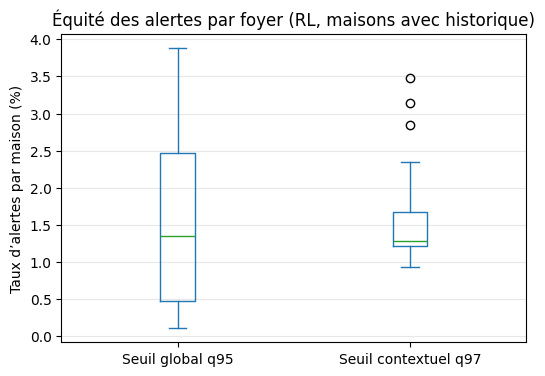

In [ ]:
# Taux d’alertes par maison (%)
rates_g   = df_rl_g95.groupby('house_id')['is_anomaly'].mean().mul(100)
rates_grp = df_rl_grp97.groupby('house_id')['is_anomaly'].mean().mul(100)

box_df = pd.DataFrame({
    'Seuil global q95': rates_g.reindex(rates_grp.index),
    'Seuil contextuel q97': rates_grp
})

fig, ax = plt.subplots(figsize=(6,4))
box_df[['Seuil global q95','Seuil contextuel q97']].plot(kind='box', ax=ax)
ax.set_ylabel('Taux d’alertes par maison (%)')
ax.set_title("Équité des alertes par foyer (RL, maisons avec historique)")
ax.grid(True, axis='y', alpha=0.3)
plt.show()


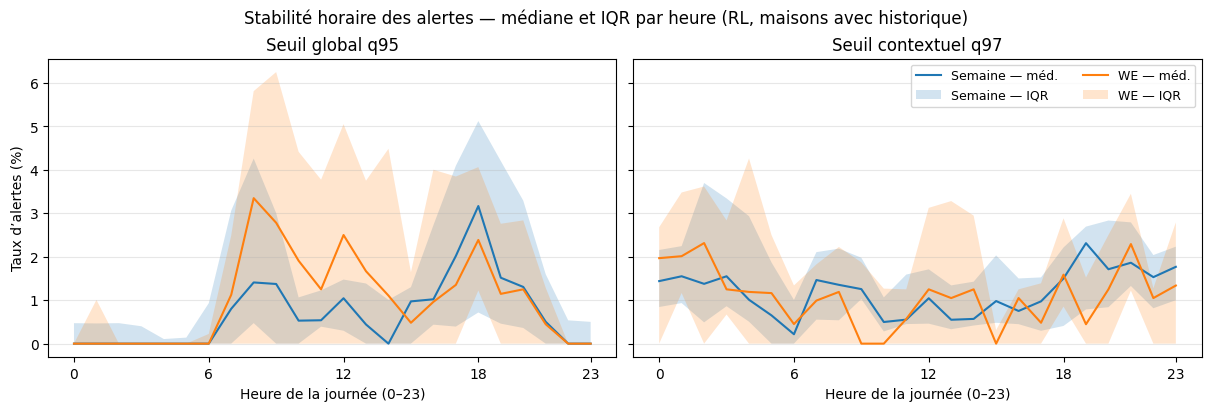

In [ ]:
def hourly_profile_iqr(df):
    """Calcule le profil horaire des taux d’alerte en renvoyant, pour chaque heure et type de jour (semaine/WE), la médiane et l’IQR des taux inter-maisons."""

    tmp = df.copy()
    # Extraire jour/semaine & heure de la journée depuis hour_of_week (0..167)
    tmp['dow'] = (tmp['hour_of_week'] // 24)        # 0=Lun ... 6=Dim
    tmp['hod'] = (tmp['hour_of_week'] % 24)         # 0..23
    tmp['we']  = np.where(tmp['dow'] >= 5, 'WE', 'Semaine')

    # Taux d’alertes par maison × hod × (Semaine/WE)
    g = (tmp.groupby(['house_id', 'we', 'hod'])['is_anomaly']
            .mean()
            .reset_index())

    # Agrégation inter-maisons : médiane + IQR par hod × (Semaine/WE)
    prof = (g.groupby(['we', 'hod'])['is_anomaly']
              .agg(med='median',
                   q1=lambda x: np.quantile(x, 0.25),
                   q3=lambda x: np.quantile(x, 0.75))
              .reset_index())
    return prof

# Profils pour les deux méthodes
prof_g   = hourly_profile_iqr(df_rl_g95)
prof_grp = hourly_profile_iqr(df_rl_grp97)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)

for ax, prof, title in [(axes[0], prof_g, 'Seuil global q95'),
                        (axes[1], prof_grp, 'Seuil contextuel q97')]:
    for band_label in ['Semaine', 'WE']:
        sub = prof[prof['we'] == band_label].sort_values('hod')
        # Ligne = médiane, Bande = IQR (25–75)
        ax.plot(sub['hod'], sub['med'] * 100, label=f'{band_label} — méd.')
        ax.fill_between(sub['hod'], sub['q1'] * 100, sub['q3'] * 100, alpha=0.2,
                        label=f'{band_label} — IQR')
    ax.set_title(title)
    ax.set_xlabel('Heure de la journée (0–23)')
    ax.set_xticks([0, 6, 12, 18, 23])
    ax.grid(True, axis='y', alpha=0.3)

axes[0].set_ylabel('Taux d’alertes (%)')

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[:2] + handles[2:4], labels[:2] + labels[2:4], ncol=2, fontsize=9)

plt.suptitle("Stabilité horaire des alertes — médiane et IQR par heure (RL, maisons avec historique)")
plt.show()


## S2 - Mode progressif

In [ ]:
def loho_folds_with_pools(df, features, model, target='Aggregate',
                          time_col='Datetime', house_col='house_id', test_frac=0.2):
    """
    Pour chaque foyer test:
      - calcule un cutoff temporel (80/20) sur la timeline complète de ce foyer,
      - entraîne le modèle sur le pool (autres maisons <= cutoff),
      - prédit sur la maison test (20% récents) et sur le pool train,
      - renvoie métriques et DataFrames `df_house` et `df_pool` (avec résidus et 'hour_of_week') pour calibrer les seuils.
    """

    assert 'hour_of_week' in df.columns, "hour_of_week manquant"

    outputs = []
    df = df.sort_values(time_col).copy()

    for house_test in sorted(df[house_col].unique()):
        # Cutoff sur la timeline complète
        df_house_all = df[df[house_col] == house_test].sort_values(time_col)
        if df_house_all.empty:
            continue
        t = df_house_all[time_col].values
        cut_idx = max(1, int(len(t) * (1 - test_frac)))
        cutoff = pd.to_datetime(t[cut_idx - 1])

        # test = 20% récents de la maison test (après cutoff)
        df_test = (df[(df[house_col] == house_test) & (df[time_col] > cutoff)]
                     .dropna(subset=features + [target]).copy())
        if df_test.empty:
            continue

        # train pool = autres maisons <= cutoff
        df_train_pool = (df[(df[house_col] != house_test) & (df[time_col] <= cutoff)]
                           .dropna(subset=features + [target]).copy())
        if df_train_pool.empty:
            continue

        # Fit
        mdl = clone(model)
        mdl.fit(df_train_pool[features], df_train_pool[target])

        # Prédictions foyer test
        X_test, y_test = df_test[features], df_test[target]
        y_pred = mdl.predict(X_test)

        df_house = df_test[[time_col, house_col, 'hour_of_week', target] + features].copy()
        df_house['y_true'] = y_test.values
        df_house['y_pred'] = y_pred
        df_house['residu'] = df_house['y_true'] - df_house['y_pred']

        # Prédictions pool train (résidus d’apprentissage)
        y_pred_train = mdl.predict(df_train_pool[features])
        df_pool = df_train_pool[[time_col, house_col, 'hour_of_week', target] + features].copy()
        df_pool['y_true'] = df_train_pool[target].values
        df_pool['y_pred'] = y_pred_train
        df_pool['residu'] = df_pool['y_true'] - df_pool['y_pred']

        # Métriques prédiction sur le foyer test
        mae  = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2   = r2_score(y_test, y_pred)

        outputs.append({
            'house_id': house_test,
            'metrics': {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'n_test': len(X_test)},
            'df_house': df_house[[time_col, house_col, 'y_true', 'y_pred', 'residu', 'hour_of_week']],
            'df_pool':  df_pool[[time_col, house_col, 'y_true', 'y_pred', 'residu', 'hour_of_week']]
        })

    return outputs

In [ ]:
def detect_zero_shot(df_pool, df_house, q=97, resid_col='residu'):
    """
    Détecte des anomalies en zéro-shot en calibrant un seuil de quantile sur la population (df_pool)
    puis en l'appliquant au foyer cible (df_house).

    Remarque : avec le groupement par défaut (house_id × hour_of_week),
    un foyer absent de df_pool utilise le seuil global de repli (quantile population).
    """
    det = GroupedPercentileDetector(q=q, resid_col=resid_col)
    det.fit(df_pool)
    return det.detect(df_house)


def detect_progressive(df_pool, df_house, q=97, update_every='7D', resid_col='residu', group_cols=('house_id', 'hour_of_week'), time_col='Datetime'):
    """Effectue une détection progressive en initialisant un seuil global sur la population puis,
      à chaque fenêtre 'update_every', applique la détection au foyer et recalibre
      les seuils avec son historique déjà observé."""

    det = GroupedPercentileDetector(q=q, resid_col=resid_col, group_cols=group_cols)
    det.fit(df_pool)

    house = df_house.sort_values(time_col).copy()
    house[time_col] = pd.to_datetime(house[time_col])
    outs, seen = [], []

    for _, chunk in house.groupby(house[time_col].dt.floor(update_every), sort=True):
        outs.append(det.detect(chunk))                              # détection sur la fenêtre courante
        seen.append(chunk)                                          # ajout à l'historique du foyer
        det.fit(pd.concat(seen, ignore_index=True))                 # recalibrage sur l'historique observé

    return pd.concat(outs, ignore_index=True)


In [ ]:
features = feature_sets['realiste']
folds = loho_folds_with_pools(df_fe, features, LinearRegression())

all_eval_zero = []
all_eval_prog = []

for fold in folds:
    df_pool  = fold['df_pool']   # résidus des autres foyers
    df_house = fold['df_house']  # résidus du foyer test

    # zero-shot
    df_z = detect_zero_shot(df_pool, df_house, q=83)
    sum_z = eval_detection(df_z)
    all_eval_zero.append({'house_id': fold['house_id'], **fold['metrics'], **sum_z})

    # progressif
    df_p = detect_progressive(df_pool, df_house, q=97, update_every='14D')
    sum_p = eval_detection(df_p)
    all_eval_prog.append({'house_id': fold['house_id'], **fold['metrics'], **sum_p})

df_eval_zero_rl = pd.DataFrame(all_eval_zero)
df_eval_prog_rl = pd.DataFrame(all_eval_prog)

# Totaux tous foyers
tot_kWh_zero = df_eval_zero_rl['excess_overuse_kWh_total'].sum()
tot_ep_zero  = df_eval_zero_rl['episodes_total'].sum()
tot_kWh_prog = df_eval_prog_rl['excess_overuse_kWh_total'].sum()
tot_ep_prog  = df_eval_prog_rl['episodes_total'].sum()

print(f"ZERO-SHOT — Total kWh: {tot_kWh_zero:.2f} | Total épisodes: {tot_ep_zero}")
print(f"PROGRESSIF — Total kWh: {tot_kWh_prog:.2f} | Total épisodes: {tot_ep_prog}")

print("Résumé ZERO-SHOT (médian par foyer):")
print(df_eval_zero_rl.median(numeric_only=True).round(2))

print("\nRésumé PROGRESSIF (médian par foyer):")
print(df_eval_prog_rl.median(numeric_only=True).round(2))


ZERO-SHOT — Total kWh: 1478.32 | Total épisodes: 5610
PROGRESSIF — Total kWh: 733.19 | Total épisodes: 5462
Résumé ZERO-SHOT (médian par maison):
house_id                                 10.50
MAE                                     190.78
RMSE                                    404.10
R2                                        0.39
n_test                                 6866.50
alert_rate_global_%                       4.94
equity_std_houses_pts                      NaN
stability_std_hours_pts                   6.03
episodes_total                          216.00
episodes_per_day_median_house             3.96
excess_overuse_kWh_total                 61.56
impact_kWh_per_episode_median_house       0.17
score_p95                                 4.52
score_p99                                 5.50
share_score_gt2_%                        45.31
share_score_gt3_%                        20.77
dtype: float64

Résumé PROGRESSIF (médian par maison):
house_id                                 10.50


Evaluation de différentes cadence de calibration

In [ ]:
def eval_progressif(period):
    """Retourne un DataFrame par maison avec les métriques d''eval_detection'
       + le taux d'alertes (%) à partir des détections progressives q=97."""
    rows = []
    for fold in folds:
        df_pool, df_house = fold['df_pool'], fold['df_house']
        df_p = detect_progressive(df_pool, df_house, q=97, update_every=period)
        rate_pct = 100.0 * df_p['is_anomaly'].mean()
        sums = eval_detection(df_p)
        rows.append({'house_id': fold['house_id'],
                     **fold.get('metrics', {}),
                     **sums,
                     'alert_rate_global_%': rate_pct})
    return pd.DataFrame(rows)

def approx_updates_per_house(period):
    """Approximation du nombre d'updates/foyer sur la fenêtre test."""
    delta = pd.to_timedelta(period)
    ups = []
    for fold in folds:
        t = pd.to_datetime(fold['df_house']['Datetime'])
        if len(t) == 0:
            continue
        n = max(1, int(np.ceil((t.max() - t.min()) / delta)))
        ups.append(n)
    return float(np.median(ups)) if ups else np.nan


In [ ]:
CADENCES = ['7D','14D','30D']

evals = {
    '7D':  eval_progressif('7D'),
    '14D': eval_progressif('14D'),
    '30D': eval_progressif('30D'),
}

/tmp/ipython-input-2345550162.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(rates_data, labels=labels, showmeans=True)


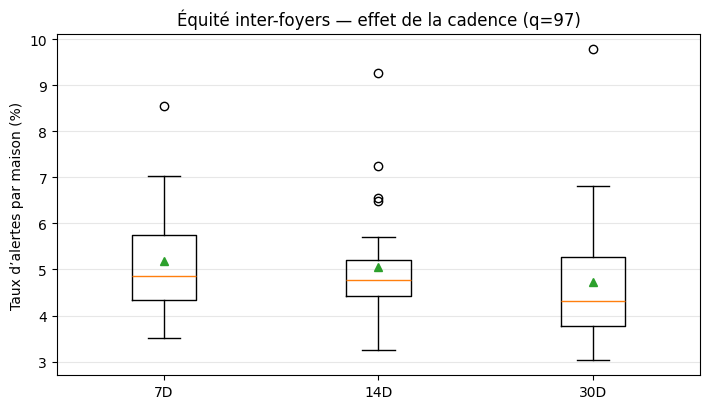

In [ ]:
# === FIGURE : Équité inter-foyers vs cadence (boxplots des taux %) ===

rates_data, labels = [], []
for per in CADENCES:
    s = evals[per]['alert_rate_global_%'].dropna().values
    rates_data.append(s)
    labels.append(per)

fig, ax = plt.subplots(figsize=(7.2, 4.2))
ax.boxplot(rates_data, labels=labels, showmeans=True)
ax.set_ylabel("Taux d’alertes par maison (%)")
ax.set_title("Équité inter-foyers — effet de la cadence (q=97)")
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# === TABLEAU : résumé par cadence (médianes par foyer) ===
def iqr(s):
    return s.quantile(0.75) - s.quantile(0.25)

rows = []
for per, df in evals.items():
    row = {
        'Cadence': per,
        'Maj/maison (méd.)': approx_updates_per_house(per),
        'Taux alertes % (méd.)': df['alert_rate_global_%'].median(),
        'Équité (IQR pts)': iqr(df['alert_rate_global_%']),
        'Épisodes/jour (méd.)': df['episodes_per_day_median_house'].median() if 'episodes_per_day_median_house' in df.columns else float('nan'),
        'kWh/1000 (méd.)': (1000.0 * df['excess_overuse_kWh_total'] / df['episodes_total'].replace(0, np.nan)).median(),
        'Score p95 (méd.)': df['score_p95'].median() if 'score_p95' in df.columns else float('nan'),
    }
    rows.append(row)

tbl = (pd.DataFrame(rows)
         .sort_values('Cadence')
         .reset_index(drop=True))

tbl_round = tbl.copy()
for c in ['Maj/maison (méd.)','Taux alertes % (méd.)','Équité (IQR pts)',
          'Épisodes/jour (méd.)','kWh/1000 (méd.)','Score p95 (méd.)']:
    tbl_round[c] = tbl_round[c].astype(float).round(2)

tbl_round


,Cadence,Maj/maison (méd.),Taux alertes % (méd.),Équité (IQR pts),Épisodes/jour (méd.),kWh/1000 (méd.),Score p95 (méd.)
0,14D,9.0,4.76,0.78,3.78,135.55,18.60
1,30D,4.0,4.31,1.50,3.88,135.61,20.95
2,7D,17.0,4.85,1.42,3.73,131.23,19.76


# Tuning RF

In [ ]:
# Jeu de variables utilisé pour l'entraînement (scénario réaliste)
features = feature_sets['realiste']
y_col = TARGET_COL

# Split au niveau "maison" pour éviter toute fuite temporelle entre foyers
rng = np.random.default_rng(42)  # reproductibilité
houses = np.array(sorted(df_fe['house_id'].unique()))
n_dev = max(1, int(0.2 * len(houses)))            # ~20% des maisons en DEV
if n_dev >= len(houses):                           # EVAL non vide
    n_dev = max(1, len(houses) - 1)
DEV_HOUSES = rng.choice(houses, size=n_dev, replace=False)
EVAL_HOUSES = np.array([h for h in houses if h not in DEV_HOUSES])
print(f"DEV: {len(DEV_HOUSES)} maisons | EVAL: {len(EVAL_HOUSES)} maisons")

# Données DEV triées chronologiquement
df_dev = df_fe[df_fe['house_id'].isin(DEV_HOUSES)].copy()
df_dev['Datetime'] = pd.to_datetime(df_dev['Datetime'])
df_dev = df_dev.sort_values('Datetime').reset_index(drop=True)
X_dev, y_dev = df_dev[features], df_dev[y_col]

# Validation croisée temporelle
tscv = TimeSeriesSplit(n_splits=3)

# Espace de recherche RF
param_dist = {
    "n_estimators": [150, 250, 350],
    "max_depth": [10, 14, 16, 20, 24],
    "min_samples_leaf": [5, 10, 20, 40],
    "min_samples_split": [2, 10, 20],
    "max_features": ["sqrt", 0.5, 0.8, 1.0],
    "bootstrap": [True],
    "max_samples": [0.6, 0.8, 1.0],
}

# Recherche aléatoire, score = -RMSE
search = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_dist,
    n_iter=24,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    refit=False,
    verbose=2
)

search.fit(X_dev, y_dev)

# Sélection : parmi les modèles à performance proche du meilleur on retient le plus simple (contrôle de complexité)
cv = search.cv_results_
mu = cv["mean_test_score"]      # moyenne des -RMSE sur les folds
std = cv["std_test_score"]      # écart-type
n_splits = tscv.get_n_splits()

best_idx = mu.argmax()
mu_best = mu[best_idx]
se_best = std[best_idx] / np.sqrt(n_splits)   # erreur standard du meilleur
threshold = mu_best - se_best                 # fenêtre de modèles proches

ok = mu >= threshold

def params_at(i):
    return {k.replace("param_", ""): cv[k][i] for k in cv if k.startswith("param_")}

def complexity_key(i):
    # Heuristique de complexité : n_estimators × profondeur
    p = params_at(i)
    depth = p["max_depth"] if p["max_depth"] is not None else 30
    return p["n_estimators"] * depth

idxs = [i for i in range(len(mu)) if ok[i]]
chosen_idx = min(idxs, key=complexity_key)   # plus petit produit = plus simple
best_params = params_at(chosen_idx)

# Modèle retenu
rf_best = RandomForestRegressor(n_jobs=-1, random_state=42, **best_params)


In [ ]:
best_params = search.cv_results_["params"][chosen_idx]

In [ ]:
# Données d'éval (foyers EVAL, jamais vus au tuning)
df_eval = df_fe[df_fe['house_id'].isin(EVAL_HOUSES)].copy()
df_eval['Datetime'] = pd.to_datetime(df_eval['Datetime'])
df_eval = df_eval.sort_values('Datetime').reset_index(drop=True)

rf_default = RandomForestRegressor(n_jobs=-1, random_state=42)  # baseline intra-modèle

# Évaluations 80/20 interne (chronologique) sur EVAL
res_tuned  = train_and_eval(df_eval, features, rf_best,     target=TARGET_COL)
res_def    = train_and_eval(df_eval, features, rf_default,  target=TARGET_COL)

cmp = pd.DataFrame({
    'model':        ['RF_tuned','RF_default'],
    'eval_MAE':     [res_tuned['MAE'],  res_def['MAE']],
    'eval_RMSE':    [res_tuned['RMSE'], res_def['RMSE']],
    'eval_R2':      [res_tuned['R2'],   res_def['R2']],
    'Train_s':      [res_tuned['fit_time_s'],    res_def['fit_time_s']],
    'ms/sample':    [res_tuned['ms_per_sample'], res_def['ms_per_sample']],
    'Size_MB':      [res_tuned['model_size_mb'], res_def['model_size_mb']],
}).round({'eval_MAE':1,'eval_RMSE':1,'eval_R2':3,'Train_s':2,'ms/sample':3,'Size_MB':2})

# Deltas vs défaut (négatif = mieux pour erreurs/temps/taille ; positif = mieux pour R2)
ref = cmp.loc[cmp['model']=='RF_default'].iloc[0]
for col in ['eval_MAE','eval_RMSE','eval_R2','Train_s','ms/sample','Size_MB']:
    cmp[f'Δ{col}'] = (cmp[col] - ref[col]).round(3)

print("=== RF hyperparams — comparaison intra-modèle sur EVAL (intérêt du tuning) ===")
print(cmp.to_markdown(index=False))
